In [2]:
import os, cv2
import torch
from torch import nn
from resnet50_ft_dag import resnet50_ft_dag
import mtcnn

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

users_path = os.path.join(os.getcwd(), 'users')

Using TensorFlow backend.


# Baixe o modelo treinado para reconhecimento de faces
Demora um pouco, mas vai!

In [ ]:
import requests

weights_path = 'http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/resnet50_ft_dag.pth'
r = requests.get(weights_path, allow_redirects=True)

open('resnet50_ft_dag.pth', 'wb').write(r.content)

# Salvando imagens das novas usuárias!

In [2]:
def save_user(root_path, username):
    
    save_path = os.path.join(root_path, username)
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    
    vid = cv2.VideoCapture(0) 

    imgs = []
    while(True): 

        # Capture the video frame 
        # by frame ppppppppq
        ret, frame = vid.read() 

        # Display the resulting frame 
        cv2.imshow('frame', frame) 

        # the 'q' button is set as the 
        # quitting button you may use any 
        # desired button of your choice 

        if cv2.waitKey(1) & 0xFF == ord('w'):
            imgs.append(frame)
            cv2.imwrite(os.path.join(save_path, '{0}.png'.format(len(imgs))), frame)
            print('{0} frames capturados'.format(len(imgs)))
            
            if len(imgs) == 10: break

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break

    # After the loop release the cap object 
    vid.release() 
    # Destroy all the windows 
    cv2.destroyAllWindows() 
    
save_user(users_path, 'mila')

1 frames capturados
2 frames capturados
3 frames capturados
4 frames capturados
5 frames capturados
6 frames capturados
7 frames capturados
8 frames capturados
9 frames capturados
10 frames capturados


# Guardando features e métricas de referência de cada usuária

In [5]:
model = resnet50_ft_dag('resnet50_ft_dag.pth')
print(model)

detector = mtcnn.MTCNN()
metric = nn.L1Loss()

Resnet50_ft_dag(
  (conv1_7x7_s2): Conv2d(3, 64, kernel_size=[7, 7], stride=(2, 2), padding=(3, 3), bias=False)
  (conv1_7x7_s2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_relu_7x7_s2): ReLU()
  (pool1_3x3_s2): MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
  (conv2_1_1x1_reduce): Conv2d(64, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
  (conv2_1_1x1_reduce_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_1x1_reduce_relu): ReLU()
  (conv2_1_3x3): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
  (conv2_1_3x3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_3x3_relu): ReLU()
  (conv2_1_1x1_increase): Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
  (conv2_1_1x1_increase_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [6]:
def run_all(identity):
    path = os.path.join(users_path, identity)
    all_feats = []

    for img in os.listdir(path):
        if img[-3:] != 'png': continue

        pixels = Image.open(os.path.join(path, img) ) 
        pixels = np.array(pixels, dtype=np.uint8)

        faces = detector.detect_faces(pixels)
        x, y, width, height = faces[0]['box']
        face = pixels[y:y+height, x:x+width,:]

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs[0].imshow(pixels)
        axs[1].imshow(face)

        face = Image.fromarray(face, 'RGB')
        face = transforms.Resize( (224, 224) )(face)
        face = transforms.ToTensor()(face).unsqueeze(0)

        class_, feature = model(face)

        all_feats.append(feature.detach().cpu().data.squeeze())

        del pixels, faces, face

    all_losses = []
    for k in range(len(all_feats)):
        for j, feat in enumerate(all_feats):
            if k == j: continue
            all_losses.append(metric(all_feats[k], feat) )
    all_losses = np.asarray(all_losses)
    print(np.mean(all_losses), np.std(all_losses))
    
    all_feats = np.asarray([feat.numpy() for feat in all_feats])
    np.savez_compressed(os.path.join(path, 'referencia'), all_feats=all_feats, all_losses=all_losses)
    

Mila


..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out)


0.2508288 0.020894203
Vivi
0.24087061 0.03990383


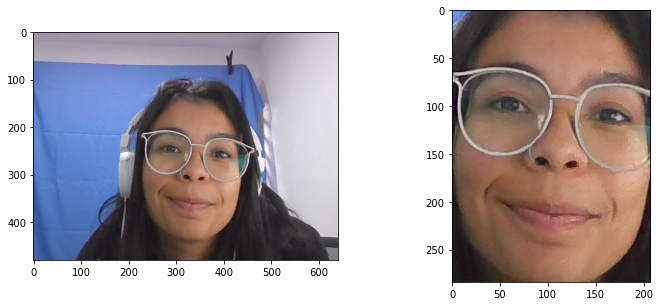

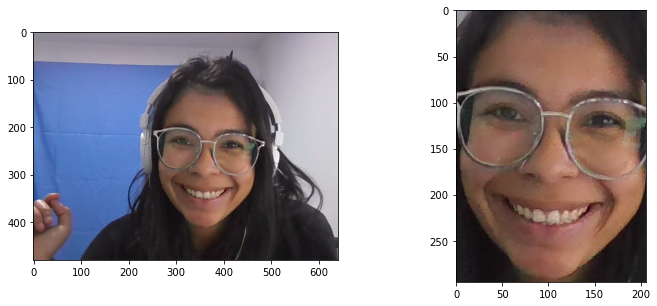

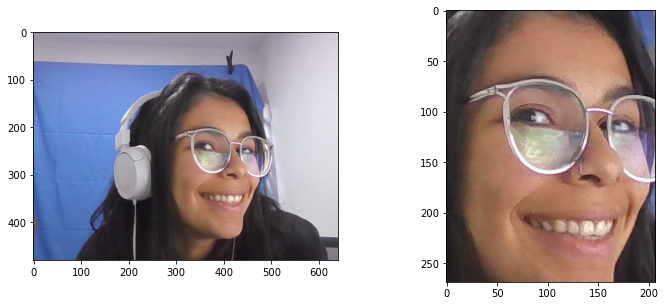

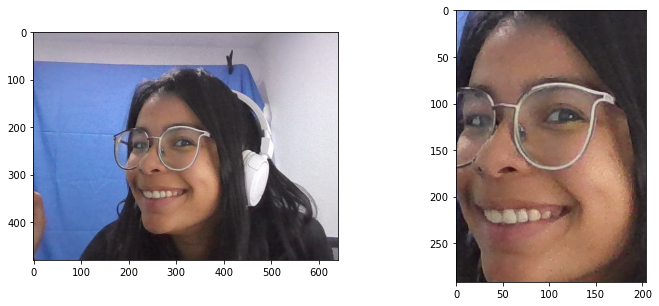

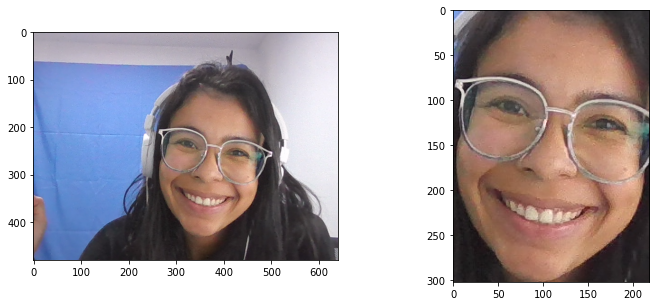

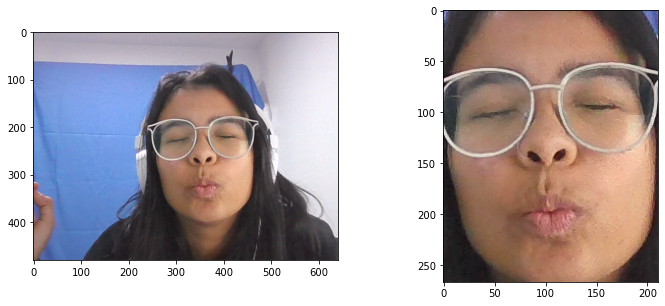

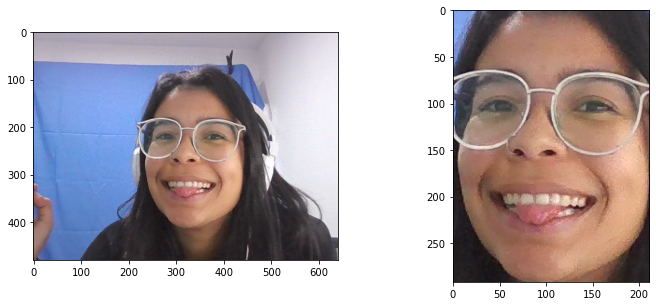

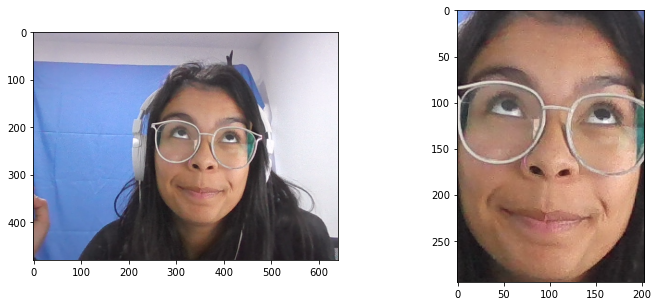

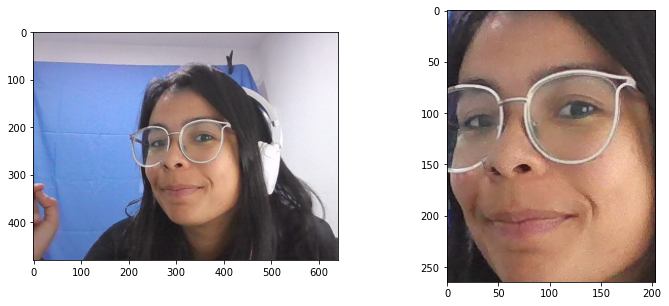

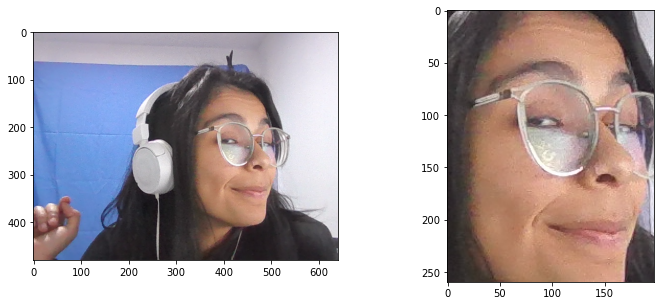

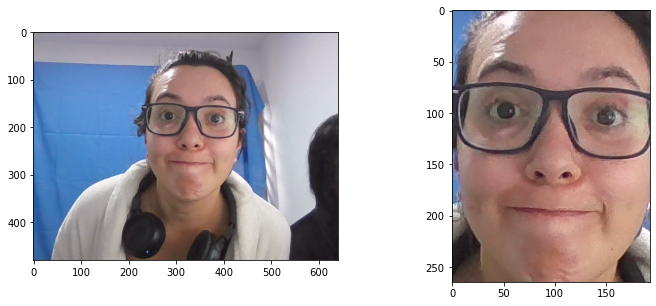

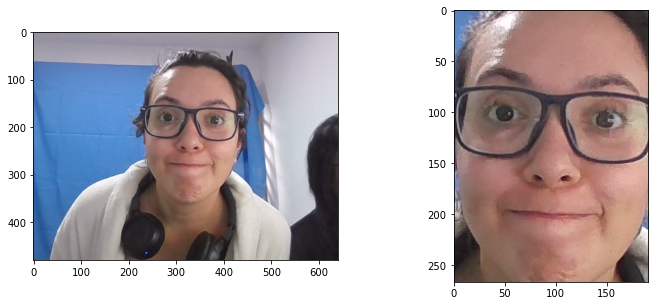

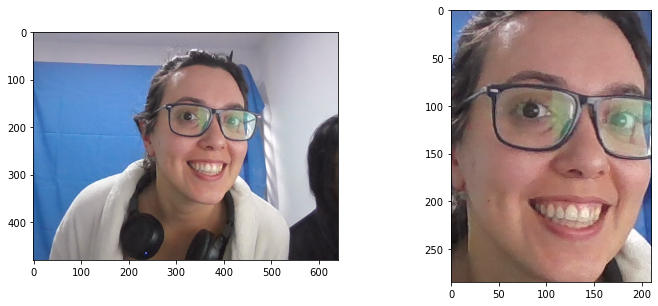

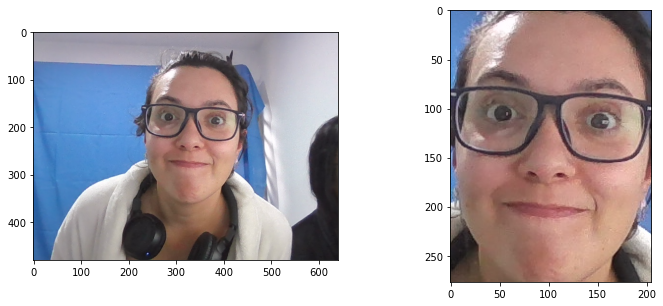

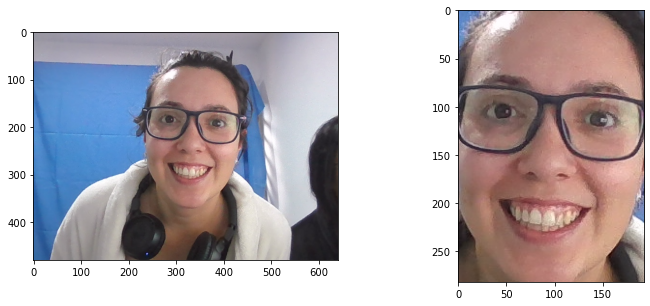

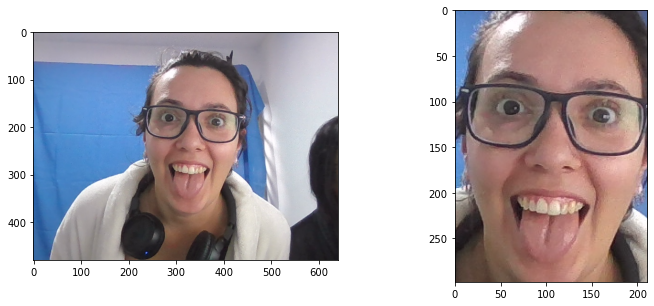

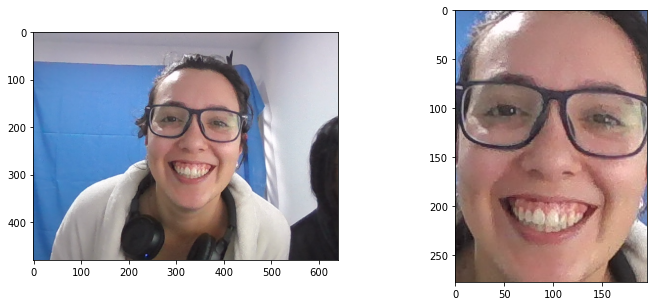

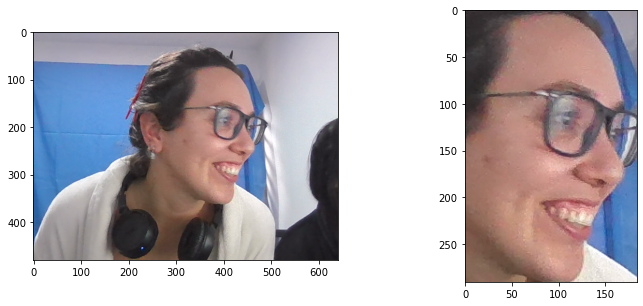

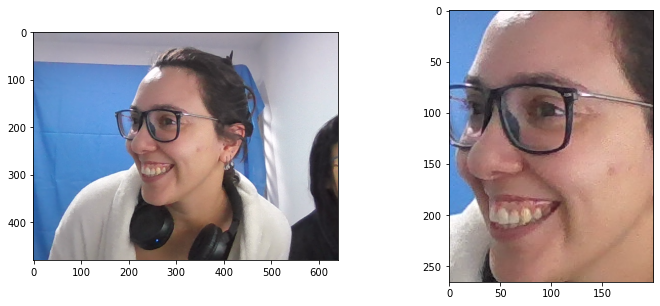

In [7]:
for user in os.listdir(users_path):
    print(user.capitalize())
    run_all(user)

# Teste com imagens nunca antes vistas!

In [3]:
def get_new_img():

    vid = cv2.VideoCapture(0) 

    ret = []
    while(True): 

        # Capture the video frame 
        # by frame ppppppppq
        ret, frame = vid.read() 

        # Display the resulting frame 
        cv2.imshow('frame', frame) 

        # the 'q' button is set as the 
        # quitting button you may use any 
        # desired button of your choice 

        if cv2.waitKey(1) & 0xFF == ord('w'):
            ret = frame
            print('1 frame capturado')
            break

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break

    # After the loop release the cap object 
    vid.release() 
    # Destroy all the windows 
    cv2.destroyAllWindows() 
    
    return ret

1 frame capturado
Identidade:  Mila


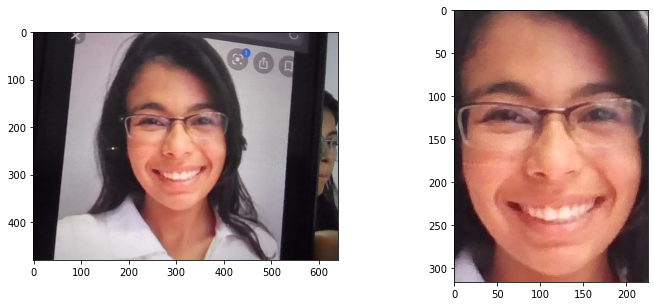

In [7]:
# Pega nova imagem
pixels = cv2.cvtColor(get_new_img(), cv2.COLOR_BGR2RGB)
pixels = np.array(pixels, dtype=np.uint8)

# Detecta faces e recorta face alinhada
faces = detector.detect_faces(pixels)
x, y, width, height = faces[0]['box']
face = pixels[y:y+height, x:x+width,:]

# Plot da imagem e da face recortada
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(pixels)
axs[1].imshow(face)

# Transformações na imagem e extração de características
face = Image.fromarray(face, 'RGB')
face = transforms.Resize( (224, 224) )(face)
face = transforms.ToTensor()(face).unsqueeze(0)

class_, feature = model(face)
feature = feature.detach().cpu().data.squeeze()

# Compara feature da nova imagem com as referências
# previamente armazenadas.

reconhecido = False
users_path = os.path.join(os.getcwd(), 'users')
for user in os.listdir(users_path):
    user_ref = os.path.join(users_path, user, 'referencia.npz')
    user_ref = np.load(user_ref)
    all_feats = user_ref['all_feats']
    all_losses = user_ref['all_losses']
    
    all_dist = []
    for feat in all_feats:
        all_dist.append(metric(feature, torch.from_numpy(feat) ))
        
    # Critério de identificação. Para cada usuário:
    #    calcule a média da distância da nova imagem com todas as imagens de referência
    #    compare com a média da diferença das imagens de referência entre si
    #    se a diferença estiver dentro de 1 desvio padrão, é possível que seja a pessoa!
    if abs(np.mean(all_dist) - np.mean(all_losses)) < np.std(all_losses):
        reconhecido = True
        print('Identidade: ', user.capitalize())

if not reconhecido:
    print('Usuário não identificado')
# all_feats.append()

# del pixels, faces, face